In [1]:
from IPython.display import display, HTML, Image
import matplotlib
import matplotlib.pyplot as plt
import torch
import sys  
import os
from functools import partial

sys.path.insert(0, '../../..')

from dynnn.simulation.mve_ensemble import MveEnsembleMechanics
from dynnn.simulation.mve_ensemble.viz import visualize_trajectory, plot_energy
from dynnn.simulation.mve_ensemble.mve_ensemble import energy_conservation_loss, calc_kinetic_energy, get_initial_conditions
from dynnn.train.pinn_train import pinn_train as train
from dynnn.utils import load_model, load_stats

In [2]:
import argparse

def get_args():
    parser = argparse.ArgumentParser(allow_abbrev=False)
    parser.add_argument('--device', default="cpu", type=str, help="device to run on")
    parser.add_argument('--batch_size', default=10000, type=int, help='batch size')
    parser.add_argument('--hidden_dim', default=3000, type=int, help='hidden dimension of mlp')
    parser.add_argument('--rl_state_dim', default=500, type=int, help='dim of state space for reinforcement learning')
    parser.add_argument('--rl_param_dim', default=500, type=int, help='dim of param space for reinforcement learning')
    parser.add_argument('--learn_rate', default=1e-4, type=float, help='learning rate')
    parser.add_argument('--weight_decay', default=1e-5, type=float, help='weight decay')
    parser.add_argument('--total_steps', default=40000, type=int, help='number of gradient steps')
    parser.add_argument('--n_bodies', default=20, type=int, help='number of particles')
    parser.add_argument('--n_dims', default=3, type=int, help='number of dimensions')
    parser.add_argument('--model', default=None, type=str, help='model file to load')
    parser.add_argument('--verbose', default=False, type=bool, help='is notebook verbose? shows extra stuff that takes time to compute.')
    parser.add_argument('--patience', default=10, type=int, help='patience for early stopping')
    parser.add_argument('--tolerance', default=1e-1, type=float, help='tolerance for early stopping')
    parser.add_argument('--min_epochs', default=5, type=int, help='minimum number of epochs before early stopping / saving model')
    parser.add_argument('--steps_per_epoch', default=200, type=int, help='steps per epoch')
    parser.add_argument('--field_type', default='conservative', type=str, help='type of vector field to learn') # solenoidal, conservative, port, both
    parser.set_defaults(feature=True)
    return parser.parse_known_args()[0]

args = get_args()

torch.set_default_device(args.device)

In [3]:
mechanics = MveEnsembleMechanics()

def plot_energy_from_coords(r, v, time, masses):
    pe = mechanics.no_bc_potential_fn(r).detach().cpu()
    ke = calc_kinetic_energy(v, masses).detach().cpu()
    te = pe + ke

    plot_energy(pe, ke, te, time.cpu())

In [4]:
y0, masses = get_initial_conditions(args.n_bodies, args.n_dims)

if args.verbose:
    r, v, dr, dv, time = mechanics.get_trajectory({ "y0": y0, "masses": masses }).dict().values()
    plot_energy_from_coords(r, v, time, masses)
    ani = visualize_trajectory(r.detach().cpu(), len(time), mechanics.domain)
    display(HTML(ani.to_jshtml()))

In [5]:
if args.verbose:
    ani.save(sys.path[0] + '/../images/mve_ensemble.gif', writer='pillow')
    display(Image(filename=sys.path[0] + '/../images/mve_ensemble.gif'))

In [6]:
data = mechanics.get_dataset({}, { "y0": y0, "masses": masses })

Loading hamiltonian data from mve_ensemble_data-hamiltonian.pkl


In [7]:
if args.verbose:
    data_r, data_v = [v.squeeze(-2) for v in torch.split(data["x"][0], 1, dim=-2)]
    plot_energy_from_coords(data_r, data_v, data["time"], masses)
    ani = visualize_trajectory(data_r, len(data["time"]), mechanics.domain)
    display(HTML(ani.to_jshtml()))

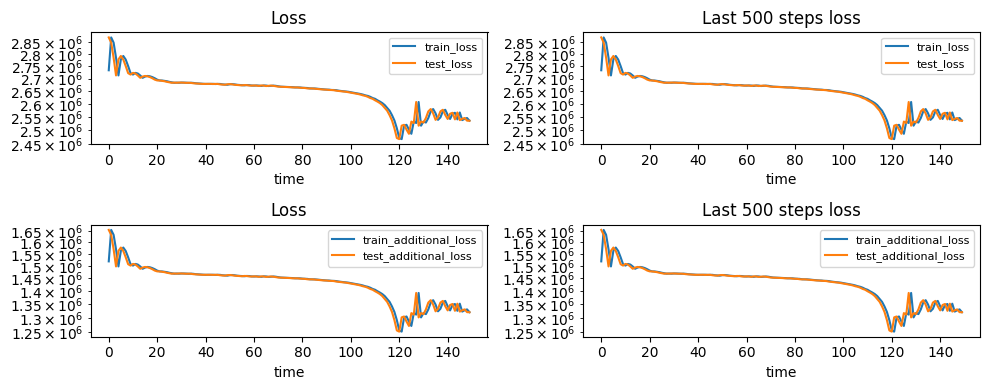

step 149, train_loss 2.5359e+06, additional_loss 1.3203e+06, test_loss 2.5356e+06, test_additional_loss 1.3200e+06


In [8]:
# load or train model
%matplotlib inline


def plot_loss(stats: dict, zoom_length: int = 500, key_sets: list[list[str]] | None = None):
    if key_sets is None:
        key_sets = [stats.keys()]

    if not 'fig' in vars():
        fig, axes = plt.subplots(len(key_sets), 2, figsize=(10, 4))

    for i, keys in enumerate(key_sets):
        axes[i][0].clear()
        axes[i][0].set_title("Loss")
        axes[i][0].set_xlabel("time")
        for key in keys:
            axes[i][0].plot(stats[key], label=key)
        axes[i][0].legend(fontsize=8)
        axes[i][0].set_yscale("log")

        axes[i][1].clear()
        axes[i][1].set_title(f"Last {zoom_length} steps loss")
        axes[i][1].set_xlabel("time")
        for key in keys:
            axes[i][1].plot(stats[key][-zoom_length:], label=key)
        axes[i][1].legend(fontsize=8)
        axes[i][1].set_yscale("log")
        fig.tight_layout()
    display(fig, clear=True)

if args.model is None:
    args.additional_loss = partial(energy_conservation_loss, masses=masses)
    # args.additional_loss = None
    model, stats = train(args, data, partial(plot_loss, key_sets=[["train_loss", "test_loss"], ["train_additional_loss", "test_additional_loss"]]))
else:
    model = load_model(args.model)
    stats = load_stats(args.model)
    plot_loss(stats)

In [ ]:
# plot model output

test_y0, test_masses = get_initial_conditions(args.n_bodies, args.n_dims)
initial_state = test_y0.clone().detach().requires_grad_()
r, v, dr, dv, time = mechanics.get_trajectory({"y0": initial_state, "masses": test_masses, "model": model}).dict().values()
plot_energy_from_coords(r, v, time, test_masses)

ani_model = visualize_trajectory(r, len(time), mechanics.domain)
HTML(ani_model.to_jshtml())